In [34]:
import pandas as pd
import glob
import numpy as numpy
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import seaborn as sns
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, BatchNormalization, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam

from multiprocessing import Process, Pool

import os
import multiprocessing as mp
import warnings
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read in data
- Test checking for today's date

In [37]:

def read_in_data(check_recent_date=True, recent_date_check=datetime.datetime.now().date()):
    dict_of_stocks_and_dfs = {}
    for file_ in glob.glob('../data/updated_historical_stock_and_etf_data/*.csv'):
        stock_name = file_.rsplit("/")[-1].split('_')[0].lower() 
        print(f"Reading in {stock_name}")
        df_  = pd.read_csv(f"{file_}")
        # ensure we have the most recent data
        try:
            most_recent_date = pd.to_datetime(df_.date.max())
            oldest_date = pd.to_datetime(df_.date.min())

            oldest_date_bool = oldest_date < datetime.datetime(2017,1,2).date()
            recent_date_bool = most_recent_date == recent_date_check

            if oldest_date_bool and recent_date_bool:
                dict_of_stocks_and_dfs[stock_name] = df_.sort_values('date')
            elif oldest_date_bool and not check_recent_date:
                dict_of_stocks_and_dfs[stock_name] = df_.sort_values('date')            
            else:
                print(f"Stock {stock_name} most recent date is {most_recent_date} oldest date is {oldest_date}. Skipping it")
        except Exception:
            continue
    return dict_of_stocks_and_dfs

In [38]:
dict_of_stocks_and_dfs = read_in_data(recent_date_check=datetime.datetime(2020,6,22).date())

Reading in mcri
Stock mcri most recent date is 2020-06-05 00:00:00 oldest date is 2005-02-25 00:00:00. Skipping it
Reading in amrb
Stock amrb most recent date is 2020-06-05 00:00:00 oldest date is 2005-02-25 00:00:00. Skipping it
Reading in inn
Stock inn most recent date is 2020-06-12 00:00:00 oldest date is 2017-01-03 00:00:00. Skipping it
Reading in so
Stock so most recent date is 2020-06-19 00:00:00 oldest date is 1981-12-31 00:00:00. Skipping it
Reading in ftc
Stock ftc most recent date is 2020-06-05 00:00:00 oldest date is 2017-01-03 00:00:00. Skipping it
Reading in rost
Stock rost most recent date is 2020-06-19 00:00:00 oldest date is 1986-07-09 00:00:00. Skipping it
Reading in penn
Stock penn most recent date is 2020-06-05 00:00:00 oldest date is 2005-02-25 00:00:00. Skipping it
Reading in spy
Stock spy most recent date is 2020-06-19 00:00:00 oldest date is 2005-02-25 00:00:00. Skipping it
Reading in fitb
Stock fitb most recent date is 2020-06-05 00:00:00 oldest date is 1990-03-

In [39]:
len(dict_of_stocks_and_dfs.keys())

0

In [40]:
'ww' in dict_of_stocks_and_dfs.keys()

False

# Create correlation & variance features
- Daily, weekly, 30-days, 90-days, 180-days, 365-daysreturn

## Build a function to create correlation features for all pairs of stocks

In [29]:
def build_correlation_dfs(dict_of_stocks_and_dfs, n_day_rolling_features_list=[3, 5, 7, 10, 30, 180, 365], verbose=False):
    """
    Create correlation + variance based  upon daily closing stock prices for given date ranges
    
    also include daily volume
    
    We are trying to  predict 7 day correaltion
    """

    stock_features_dict = defaultdict(pd.DataFrame)
    start_time = time.time()
    
    start = time.time()
    n_stocks = len(dict_of_stocks_and_dfs.keys())
    final_feature_df = create_date_dummy_df()
    pairs_of_stocks = []
    
    for idx, first_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
        print('')
        print(f"Finished {idx/n_stocks} pct of stocks")
        print('')
        for second_idx, second_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
            stock_pair = f"{first_stock_name}_{second_stock_name}"
            reverse_pair = f"{second_stock_name}_{first_stock_name}"
            
            if (first_stock_name == second_stock_name) or (stock_pair in pairs_of_stocks)  or (reverse_pair in pairs_of_stocks): # pnr -> ual same as ual -> pnr
                continue
            else:
                pairs_of_stocks.append(stock_pair)
            if verbose:
                print('-------')
                print(f"{first_stock_name} & {second_stock_name}")
                print('-------')
            
            # here the date is not the index, yet
            first_stock_df = dict_of_stocks_and_dfs[f"{first_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{first_stock_name}"].date.isin(dict_of_stocks_and_dfs[f"{second_stock_name}"].date), :]

            #  filter second df by the dates in first

            # here the date is not the index, yet
            second_stock_df = dict_of_stocks_and_dfs[f"{second_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{second_stock_name}"].date.isin(first_stock_df.date), :]
            
            # set the date as an index and sort by date
            first_stock_df = first_stock_df.sort_values('date')
            second_stock_df = second_stock_df.sort_values('date')

            first_stock_df = first_stock_df.set_index('date')
            second_stock_df = second_stock_df.set_index('date')
            
            all_features_df = pd.DataFrame()
            for rolling_idx, rolling_day in enumerate(n_day_rolling_features_list):
                if verbose:
                    print(f"Rolling calculations for {rolling_day}")
                features_df = create_correlation_and_variance_features(
                    first_stock_df, second_stock_df, rolling_day, final_feature_df, 
                    first_stock_name=first_stock_name, second_stock_name=second_stock_name)
                   
                current_feature_cols = set(features_df.columns)
                final_feature_cols = set(final_feature_df.columns)

                
                if (f"{first_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{first_stock_name}_volume"] = list(first_stock_df.volume)
                
                if (f"{second_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{second_stock_name}_volume"] = list(second_stock_df.volume)
                    
                if rolling_idx == 0: 
                    all_features_df = features_df
                else:
                    all_features_df = all_features_df.join(features_df, on='date', lsuffix='_left')
            

                    
            all_features_df.index = pd.to_datetime(all_features_df.index)
            final_feature_df = final_feature_df.join(all_features_df, on='date')

            if verbose:
                end = time.time()
                print(f"Building all features took {(end-start)/60} minutes")
                start = time.time()

    end_time = time.time()
    print(f"Total time {(end_time-start_time) / 60} minutes for {len(pairs_of_stocks)} pairs")
    final_feature_df = add_time_feature(final_feature_df)
    return final_feature_df, pairs_of_stocks
            
        

# Note: will eventuall need to add in 0s for stocks withour correlation data with other stocks due to date range

In [30]:
def create_date_dummy_df(start_date=datetime.datetime(1980,1,1), n_years=50):
    
    #  create dummy df with dates to join against
    list_of_dates  = []
    n_days = 365*n_years
    start_date = start_date

    for i in range(n_days):
        list_of_dates.append(start_date + datetime.timedelta(i))
    df_ = pd.DataFrame(list_of_dates, columns=['date'])
    
    df_.date_ =  pd.to_datetime(df_.date)
    return df_.set_index('date')
    

In [31]:
def add_time_feature(final_stock_df):
    
    days = [i.day for i in final_stock_df.index]
    months = [i.month for i in final_stock_df.index]
    quarters = [i.quarter for i in final_stock_df.index]
    years = [i.year for i in final_stock_df.index]
    
    us_holidays = holidays.UnitedStates()
    
    h_ = np.array([i in us_holidays for i in final_stock_df.index]).astype(int)


    final_stock_df['day'] = days
    final_stock_df['month'] = months
    final_stock_df['quarter'] = quarters
    final_stock_df['year'] = years
    final_stock_df['is_holiday'] = h_
    
    return final_stock_df

In [32]:
def create_correlation_and_variance_features(first_stock_df, second_stock_df, n_days_stride, final_stock_df, 
                                             first_stock_name=None, second_stock_name=None, verbose=False):
    """
    n_days_stride: the  number of rolling days to calculate correlation for
    """
    n_rows = len(first_stock_df)

    previous_row = 0

    features_per_time_period = defaultdict(list)
    if verbose:
        print(f"Creating correlations + variance on close for {n_days_stride} days")
    
    rolling_close_df = pd.DataFrame(first_stock_df.close.rolling(
        n_days_stride).corr(second_stock_df.close)).rename(
        {'close': f"{first_stock_name}_{second_stock_name}_close_corr_rolling_{n_days_stride}_days"},axis=1).fillna(method='backfill').round(6)

    
    # add cols
    
    current_feature_cols = list(final_stock_df.columns)
    

    # as we go through different pairs will have multiple var / corr for the first stock
    # pnc_bar calcualtes corr for pnr
    #pnr_bat calculates corr for pnr
    # don't want the same cols
    if f"{first_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        
        rolling_close_std_first_stock =  first_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_first_stock
        
    if f"{second_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_close_std_second_stock =  second_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round( 6)
        rolling_close_df[f"{second_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_second_stock
        
    if f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_first_stock =  first_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_first_stock
        
    if f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_second_stock =  second_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_second_stock
    
    return rolling_close_df



In [33]:
# 2 minutes fo 210 pairs
final_stock_df, pairs_of_stocks = build_correlation_dfs(dict_of_stocks_and_dfs, verbose=False)


Finished 0.0 pct of stocks


Finished 0.02631578947368421 pct of stocks


Finished 0.05263157894736842 pct of stocks



KeyboardInterrupt: 

In [33]:
len(final_stock_df.columns)

9630

In [12]:
len(final_stock_df.columns)

6530

In [1428]:
pairs_of_stocks[:10]

['eqix_rost',
 'eqix_so',
 'eqix_emr',
 'eqix_atvi',
 'eqix_ce',
 'eqix_cern',
 'eqix_peg',
 'eqix_adbe',
 'eqix_rop',
 'eqix_are']

In [1429]:
final_stock_df.loc[~pd.isna(final_stock_df.pnr_volume), :]

,eqix_rost_close_corr_rolling_3_days,eqix_close_std_rolling_3_days,rost_close_std_rolling_3_days,eqix_volume_std_rolling_3_days,rost_volume_std_rolling_3_days,eqix_volume,rost_volume,eqix_rost_close_corr_rolling_6_days,eqix_close_std_rolling_6_days,rost_close_std_rolling_6_days,...,bac_ni_close_corr_rolling_30_days,bac_ni_close_corr_rolling_60_days,bac_ni_close_corr_rolling_90_days,bac_ni_close_corr_rolling_180_days,bac_ni_close_corr_rolling_365_days,day,month,quarter,year,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2006-01-25,0.697482,0.282852,0.068850,20062.106769,3.307482e+06,235169.0,4918853.0,0.709943,0.385182,0.121731,...,0.368948,-0.512014,-0.799915,-0.225630,-0.135606,25,1,1,2006,0
2006-01-26,-0.712630,0.131936,0.025701,175816.922796,3.364882e+06,547429.0,5432737.0,0.801974,0.384777,0.111135,...,0.379214,-0.456781,-0.807436,-0.226264,-0.140600,26,1,1,2006,0
2006-01-27,0.931257,0.353271,0.048220,156472.651685,5.959368e+05,373373.0,6107119.0,0.635272,0.402604,0.058964,...,0.427250,-0.344494,-0.803128,-0.226564,-0.144211,27,1,1,2006,0
2006-01-30,0.560951,0.349257,0.057870,109960.000183,1.163736e+06,343988.0,3840744.0,0.657181,0.371951,0.060240,...,0.473339,-0.183239,-0.787769,-0.223135,-0.144993,30,1,1,2006,0
2006-01-31,0.999991,0.206297,0.094188,84712.417773,3.034216e+06,214178.0,9849079.0,0.167156,0.273997,0.064078,...,0.506812,-0.019687,-0.769228,-0.218527,-0.145200,31,1,1,2006,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,0.921834,12.100167,2.832178,10426.116454,1.245721e+06,519465.0,3565677.0,0.806622,13.560098,2.202212,...,0.785553,0.893178,0.782362,0.478982,0.468392,20,4,2,2020,0
2020-04-21,0.883428,13.572675,4.528072,52815.552637,7.638944e+05,420730.0,4154852.0,0.831760,9.717596,3.283860,...,0.813368,0.892376,0.786006,0.486588,0.472182,21,4,2,2020,0
2020-04-22,-0.308115,7.721531,1.951692,53591.032244,4.522756e+05,433979.0,3265862.0,0.586243,9.167159,3.253450,...,0.799865,0.889803,0.788002,0.490475,0.474366,22,4,2,2020,0


In [1430]:
final_stock_df.loc[~pd.isna(final_stock_df.pnr_volume), :]

,eqix_rost_close_corr_rolling_3_days,eqix_close_std_rolling_3_days,rost_close_std_rolling_3_days,eqix_volume_std_rolling_3_days,rost_volume_std_rolling_3_days,eqix_volume,rost_volume,eqix_rost_close_corr_rolling_6_days,eqix_close_std_rolling_6_days,rost_close_std_rolling_6_days,...,bac_ni_close_corr_rolling_30_days,bac_ni_close_corr_rolling_60_days,bac_ni_close_corr_rolling_90_days,bac_ni_close_corr_rolling_180_days,bac_ni_close_corr_rolling_365_days,day,month,quarter,year,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2006-01-25,0.697482,0.282852,0.068850,20062.106769,3.307482e+06,235169.0,4918853.0,0.709943,0.385182,0.121731,...,0.368948,-0.512014,-0.799915,-0.225630,-0.135606,25,1,1,2006,0
2006-01-26,-0.712630,0.131936,0.025701,175816.922796,3.364882e+06,547429.0,5432737.0,0.801974,0.384777,0.111135,...,0.379214,-0.456781,-0.807436,-0.226264,-0.140600,26,1,1,2006,0
2006-01-27,0.931257,0.353271,0.048220,156472.651685,5.959368e+05,373373.0,6107119.0,0.635272,0.402604,0.058964,...,0.427250,-0.344494,-0.803128,-0.226564,-0.144211,27,1,1,2006,0
2006-01-30,0.560951,0.349257,0.057870,109960.000183,1.163736e+06,343988.0,3840744.0,0.657181,0.371951,0.060240,...,0.473339,-0.183239,-0.787769,-0.223135,-0.144993,30,1,1,2006,0
2006-01-31,0.999991,0.206297,0.094188,84712.417773,3.034216e+06,214178.0,9849079.0,0.167156,0.273997,0.064078,...,0.506812,-0.019687,-0.769228,-0.218527,-0.145200,31,1,1,2006,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,0.921834,12.100167,2.832178,10426.116454,1.245721e+06,519465.0,3565677.0,0.806622,13.560098,2.202212,...,0.785553,0.893178,0.782362,0.478982,0.468392,20,4,2,2020,0
2020-04-21,0.883428,13.572675,4.528072,52815.552637,7.638944e+05,420730.0,4154852.0,0.831760,9.717596,3.283860,...,0.813368,0.892376,0.786006,0.486588,0.472182,21,4,2,2020,0
2020-04-22,-0.308115,7.721531,1.951692,53591.032244,4.522756e+05,433979.0,3265862.0,0.586243,9.167159,3.253450,...,0.799865,0.889803,0.788002,0.490475,0.474366,22,4,2,2020,0


In [67]:
final_stock_df.loc[((final_stock_df.index>'2020-01-01') & (final_stock_df.index<'2021-01-01')), :][['pnr_bac_close_corr_rolling_3_days','pnr_bac_close_corr_rolling_6_days', 
                                                'pnr_bac_close_corr_rolling_8_days']].plot(figsize=(15,5))

KeyError: "None of [Index(['pnr_bac_close_corr_rolling_3_days',\n       'pnr_bac_close_corr_rolling_6_days',\n       'pnr_bac_close_corr_rolling_8_days'],\n      dtype='object')] are in the [columns]"

## Train Test Split to predict correlation over the next 7 days
- rolling evey day make a predictions about what the correlation will be for the next 7 days stock price

In [1442]:
datetime.timedelta(7)

datetime.timedelta(days=7)

- Rolling Predictions

In [54]:
# drop na
final_stock_df = final_stock_df.dropna()

In [197]:
final_stock_df

,dds_peg_close_corr_rolling_3_days,dds_close_std_rolling_3_days,peg_close_std_rolling_3_days,dds_volume_std_rolling_3_days,peg_volume_std_rolling_3_days,dds_volume,peg_volume,dds_peg_close_corr_rolling_5_days,dds_close_std_rolling_5_days,peg_close_std_rolling_5_days,...,ual_aeo_close_corr_rolling_7_days,ual_aeo_close_corr_rolling_10_days,ual_aeo_close_corr_rolling_30_days,ual_aeo_close_corr_rolling_180_days,ual_aeo_close_corr_rolling_365_days,day,month,quarter,year,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,1,1,1980,1
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2,1,1,1980,0
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3,1,1,1980,0
1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4,1,1,1980,0
1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5,1,1,1980,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2029-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,14,12,4,2029,0
2029-12-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15,12,4,2029,0
2029-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,16,12,4,2029,0


In [79]:
final_stock_df = final_stock_df.dropna()

In [124]:
# scaler=StandardScaler()
# final_stock_df = scaler.fit_transform(final_stock_df)

- Add Keras LSTM 

In [80]:
# prepare data for Keras
# (n_samples, n_timesteps (rows), n_features)
#The first dimension is the number of samples, in this case 7. 
# The second dimension is the number of time steps per sample, in this case 3, the value specified to the function. 
#Finally, the last dimension specifies the number of parallel time series or the number of variables, in this case 2 for the two parallel series.

# Let's say we use two years of data for n_timesteps (720 days)

In [43]:
N_DAY_TIMESTEPS = 720 #n days

In [2799]:
# prepare the data for LSTM model
def split_sequences(sequences, n_steps, y_col='pg_so_close_corr_rolling_7_days', start_idx=2800, n_val=50, print_idx=100): #2200
    """
    sequences = input_data
    n_steps = n_days of data to give at a time
    
    only works for the currently set y_col
    """
    if y_col not in sequences.columns:
        raise ValueError('This y col does not exist in this df')
    
    X, y = list(), list()
    X_val, y_val = list(), list()
    
    n_sequences = len(sequences)
    print('n_sequences', n_sequences)

    for i in range(start_idx, n_sequences):
        if i == start_idx:
            print(f"Training idx start at {i}")
        if (i % print_idx == 0) and i != 0:
            print(f"Pct finished = {i/n_sequences}")
            
        # find the end of this pattern
        end_ix = i + n_steps 
        total_end_ix = end_ix + n_val
        # check if we are beyond the dataset
        if (total_end_ix) > n_sequences:
            print(f"Training idx end at {end_ix}")
            print('Total idx checked', total_end_ix)
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = np.array(sequences.loc[:, sequences.columns != f"{y_col}"][i:end_ix]), np.array(
            sequences.loc[:, sequences.columns == f"{y_col}"].shift(-7).fillna(method='ffill').iloc[end_ix-1])

                                 
        X.append(seq_x)
        y.append(seq_y)
    
    val_start_idx = start_idx + n_sequences - (start_idx  + n_val -2)
    for i in range(val_start_idx, n_sequences):
        if i == val_start_idx:
            print(f"Val idx start at {val_start_idx}")
        if (i % print_idx == 0) and i != 0:
            print(f"Pct finished for val sequences = {i/n_sequences}")
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            print(f"Val idx end at {end_ix}")
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = np.array(sequences.loc[:, sequences.columns != f"{y_col}"][i:end_ix]), np.array(
            sequences.loc[:, sequences.columns == f"{y_col}"].shift(-7).fillna(method='ffill').iloc[end_ix-1])
        
        
        X_val.append(seq_x)
        y_val.append(seq_y)
    
    

    X, y, X_val, y_val = array(X), array(y), array(X_val), array(y_val)
    
    # errors for standard scaler
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors  
    
    
    scalers = {}
    for i in range(X.shape[1]):
        scalers[i] = StandardScaler()
        X[:, i, :] = scalers[i].fit_transform(X[:, i, :]) 

    print(X_val.shape)
    for i in range(X_val.shape[1]):
        X_val[:, i, :] = scalers[i].transform(X_val[:, i, :]) 
   # need  to do this again as standard scaler may have nans
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors  
    

    
    return X, y, X_val, y_val, scalers

    
    

In [34]:
X.shape

NameError: name 'X' is not defined

In [2800]:
final_stock_df = final_stock_df.dropna()
X,y, X_val, y_val, scalers = split_sequences(final_stock_df[final_stock_df.index >= '2010-01-01'],  30, start_idx=0, 
                                    n_val=200, y_col='so_pg_close_corr_rolling_7_days') # 720 steps

n_sequences 1825
Training idx start at 0
Pct finished = 0.0547945205479452
Pct finished = 0.1095890410958904
Pct finished = 0.1643835616438356
Pct finished = 0.2191780821917808
Pct finished = 0.273972602739726
Pct finished = 0.3287671232876712
Pct finished = 0.3835616438356164
Pct finished = 0.4383561643835616
Pct finished = 0.4931506849315068
Pct finished = 0.547945205479452
Pct finished = 0.6027397260273972
Pct finished = 0.6575342465753424
Pct finished = 0.7123287671232876
Pct finished = 0.7671232876712328
Pct finished = 0.821917808219178
Training idx end at 1626
Total idx checked 1826
Val idx start at 1627
Pct finished for val sequences = 0.9315068493150684
Val idx end at 1826
(169, 30, 3070)


In [2906]:
def build_keras_model(n_steps, n_features, n_units=50, dropout_pct=0.1, n_layers = 1):
    model = Sequential()
    model.add(LSTM(n_units, activation='relu', dropout=dropout_pct, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(BatchNormalization())
    for _ in range(n_layers):
        model.add(LSTM(n_units, activation='relu', dropout=dropout_pct, return_sequences=True))
        model.add(BatchNormalization())
    model.add(LSTM(n_units, activation='relu', dropout=dropout_pct))
    model.add(BatchNormalization())
    model.add(Dense(n_units))
    model.add(Dense(int(n_units/2)))
    model.add(Dense(1))
    #Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='mse', metrics=['mse'])
    return model

In [2907]:
smaller_model = build_keras_model(X.shape[1],X.shape[2])

In [2908]:
smaller_model.summary()

Model: "sequential_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_559 (LSTM)              (None, 30, 50)            624200    
_________________________________________________________________
batch_normalization_98 (Batc (None, 30, 50)            200       
_________________________________________________________________
lstm_560 (LSTM)              (None, 30, 50)            20200     
_________________________________________________________________
batch_normalization_99 (Batc (None, 30, 50)            200       
_________________________________________________________________
lstm_561 (LSTM)              (None, 50)                20200     
_________________________________________________________________
batch_normalization_100 (Bat (None, 50)                200       
_________________________________________________________________
dense_317 (Dense)            (None, 50)             

In [2909]:
X.shape

(1596, 30, 3070)

#### build a base model then freeze it
- train the last layers for other stocks

In [2910]:
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=50, verbose=1)

class PredictionCallback(Callback):    
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.validation_data[0])
        print('prediction: {} at epoch: {}'.format(y_pred, epoch))


In [2901]:
# smaller_model.save('test_smaller_model_1k_eochs.hdf5')

In [2911]:

# 100 epochs, large batch size
# 200 .22 loss
# 300 .17 loss
# 400 epochs - .15 loss ( 100 epochs in 11 mins) .25 val loss
# 500 epochs - .10 loss, .23 val loss
# 600 epochs -.08 loss .22 val loss
# 700 epochs  - .07, .22 val
# 800 epochs - .06 .23 valloss
# 900 epochs -  .05, .24 vall loss
# 1k epochs - .03, .23 val loss
#1.1k loss at .03,  val loss at .23-.24 (not decreasing, if anything we've overfit already)

# test again at 700 epochs
start = time.time()
history = smaller_model.fit(x=X, y=y, batch_size=128, epochs=800, verbose=1, 
          validation_data=(X_val, y_val), shuffle=False,  use_multiprocessing=False, callbacks=[early_stopping])
end=time.time()

print((end-start)/60,' minutes')

Train on 1596 samples, validate on 169 samples
Epoch 1/800
1596/1596 [==============================] - 9s 5ms/sample - loss: 1.8336 - mse: 1.8336 - val_loss: 26.4377 - val_mse: 26.4377
Epoch 2/800
1596/1596 [==============================] - 3s 2ms/sample - loss: 1.2110 - mse: 1.2110 - val_loss: 23.0340 - val_mse: 23.0340
Epoch 3/800
1596/1596 [==============================] - 3s 2ms/sample - loss: 1.1019 - mse: 1.1019 - val_loss: 6.2469 - val_mse: 6.2469
Epoch 4/800
1596/1596 [==============================] - 3s 2ms/sample - loss: 0.9967 - mse: 0.9967 - val_loss: 3.4068 - val_mse: 3.4068
Epoch 5/800
1596/1596 [==============================] - 3s 2ms/sample - loss: 0.8420 - mse: 0.8420 - val_loss: 131.1684 - val_mse: 131.1684
Epoch 6/800
1596/1596 [==============================] - 3s 2ms/sample - loss: 0.8262 - mse: 0.8262 - val_loss: 224.3076 - val_mse: 224.3076
Epoch 7/800
1596/1596 [==============================] - 4s 2ms/sample - loss: 0.7861 - mse: 0.7861 - val_loss: 161.699

In [2912]:
# 260 .27
predictions = []
n_rows = 30
end_idx = 100
start_idx = 0
n = len(X_val)

predictions.append(smaller_model.predict(X_val))
train_predictions = smaller_model.predict(X)

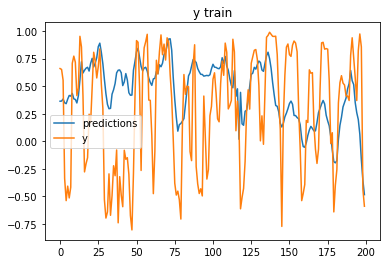

In [2913]:
# ~ 300 epochs
pd.DataFrame({'predictions':train_predictions.ravel()[:200],'y':y.ravel()[:200]}).plot(title='y train')

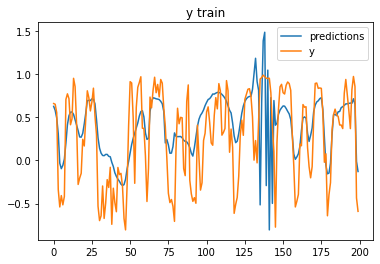

In [2892]:

pd.DataFrame({'predictions':train_predictions.ravel()[:200],'y':y.ravel()[:200]}).plot(title='y train')

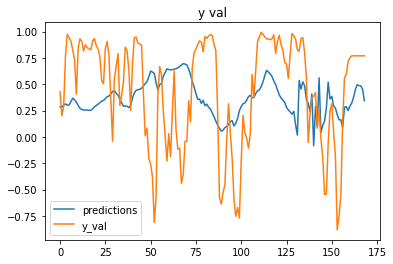

In [2914]:


pd.DataFrame({'predictions':predictions[0].ravel(),'y_val':y_val.ravel()[:200]}).plot(title='y val')

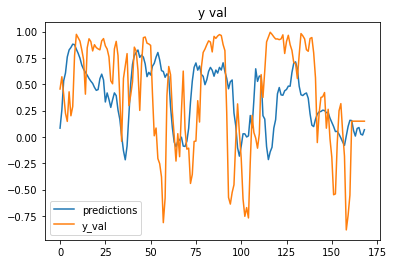

In [2678]:

pd.DataFrame({'predictions':predictions[0].ravel(),'y_val':y_val.ravel()[:200]}).plot(title='y val')

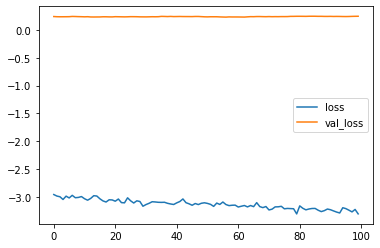

In [2677]:
history_df = pd.DataFrame(history.history)
history_df.loss = np.log(history_df.loss)
# history_df.val_loss = np.log(history_df.val_loss)
history_df[['loss', 'val_loss']].plot()

In [1498]:
final_stock_df.iloc[:, final_stock_df.columns == 'pg_so_close_corr_rolling_7_days'].iloc[-13]

pg_so_close_corr_rolling_7_days   -0.018328
Name: 2020-04-15 00:00:00, dtype: float64

In [ ]:
# now test transfer learning

In [2331]:
history_df  = pd.DataFrame(history.history)

In [2332]:
history_df['val_rmse'] = np.sqrt(history_df.val_mse)
history_df['rmse'] = np.sqrt(history_df.mse)

In [2333]:
np.mean(history_df.val_rmse)

0.5204908244169808

In [2334]:
np.mean(history_df.val_rmse[-20:])

0.5204908244169808

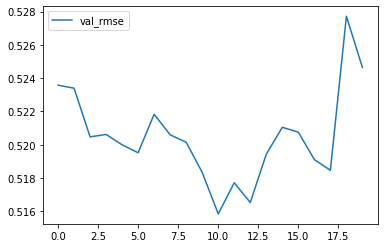

In [2335]:
history_df[['val_rmse']].plot()

In [ ]:
# smaller_model.save(f"../models/base_lstm_n_features_{X.shape[2]}_n_timesteps_{X.shape[1]}.h5")

### test transfer learning on another stock

In [2915]:
smaller_model.summary()

Model: "sequential_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_559 (LSTM)              (None, 30, 50)            624200    
_________________________________________________________________
batch_normalization_98 (Batc (None, 30, 50)            200       
_________________________________________________________________
lstm_560 (LSTM)              (None, 30, 50)            20200     
_________________________________________________________________
batch_normalization_99 (Batc (None, 30, 50)            200       
_________________________________________________________________
lstm_561 (LSTM)              (None, 50)                20200     
_________________________________________________________________
batch_normalization_100 (Bat (None, 50)                200       
_________________________________________________________________
dense_317 (Dense)            (None, 50)             

In [2917]:
# Freeze the layers except the last 5 layers
for layer in smaller_model.layers[:-5]:
    layer.trainable = False
# Check the trainable status of the individual layers

for layer in smaller_model.layers:
    print(layer, layer.trainable)

smaller_model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='mse', metrics=['mse'])

In [2918]:
smaller_model.summary()

Model: "sequential_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_559 (LSTM)              (None, 30, 50)            624200    
_________________________________________________________________
batch_normalization_98 (Batc (None, 30, 50)            200       
_________________________________________________________________
lstm_560 (LSTM)              (None, 30, 50)            20200     
_________________________________________________________________
batch_normalization_99 (Batc (None, 30, 50)            200       
_________________________________________________________________
lstm_561 (LSTM)              (None, 50)                20200     
_________________________________________________________________
batch_normalization_100 (Bat (None, 50)                200       
_________________________________________________________________
dense_317 (Dense)            (None, 50)             

- Test a new stock. Create training data

In [2919]:
X_pnr_bac.shape

(1596, 30, 3070)

In [2920]:
X_val_pnr_bac.shape

(169, 30, 3070)

In [2921]:
final_stock_df.shape

(1825, 3071)

In [2922]:
X_pnr_bac,y_pnr_bac, X_val_pnr_bac, y_val_pnr_bac, scalers_pnr_bac = split_sequences(final_stock_df[final_stock_df.index >= '2010-01-01'],  30, start_idx=0, 
                                    n_val=200, y_col='pnr_bac_close_corr_rolling_7_days') # 720 steps

n_sequences 1825
Training idx start at 0
Pct finished = 0.0547945205479452
Pct finished = 0.1095890410958904
Pct finished = 0.1643835616438356
Pct finished = 0.2191780821917808
Pct finished = 0.273972602739726
Pct finished = 0.3287671232876712
Pct finished = 0.3835616438356164
Pct finished = 0.4383561643835616
Pct finished = 0.4931506849315068
Pct finished = 0.547945205479452
Pct finished = 0.6027397260273972
Pct finished = 0.6575342465753424
Pct finished = 0.7123287671232876
Pct finished = 0.7671232876712328
Pct finished = 0.821917808219178
Training idx end at 1626
Total idx checked 1826
Val idx start at 1627
Pct finished for val sequences = 0.9315068493150684
Val idx end at 1826
(169, 30, 3070)


- Train

In [2928]:
len(pairs_of_stocks)

378

In [2932]:
(378*10)/60  # minutes

63.0

In [2933]:
# transfer learning
#  100 epochs takes  5 mins
# 200 epochs

start = time.time()
history = smaller_model.fit(x=X_pnr_bac, y=y_pnr_bac, batch_size=128, epochs=100, verbose=1, 
          validation_data=(X_val_pnr_bac, y_val_pnr_bac), shuffle=False,  use_multiprocessing=False, callbacks=[early_stopping])
end=time.time()

print((end-start)/60,' minutes')

Train on 1596 samples, validate on 169 samples
Epoch 1/100
1596/1596 [==============================] - 3s 2ms/sample - loss: 0.1849 - mse: 0.1849 - val_loss: 0.1907 - val_mse: 0.1907
Epoch 2/100
1596/1596 [==============================] - 3s 2ms/sample - loss: 0.1927 - mse: 0.1927 - val_loss: 0.1882 - val_mse: 0.1882
Epoch 3/100
1596/1596 [==============================] - 3s 2ms/sample - loss: 0.1921 - mse: 0.1921 - val_loss: 0.2013 - val_mse: 0.2013
Epoch 4/100
1596/1596 [==============================] - 3s 2ms/sample - loss: 0.1892 - mse: 0.1892 - val_loss: 0.1988 - val_mse: 0.1988
Epoch 5/100
1596/1596 [==============================] - 3s 2ms/sample - loss: 0.1932 - mse: 0.1932 - val_loss: 0.1916 - val_mse: 0.1916
Epoch 6/100
1596/1596 [==============================] - 3s 2ms/sample - loss: 0.1896 - mse: 0.1896 - val_loss: 0.1967 - val_mse: 0.1967
Epoch 7/100
1596/1596 [==============================] - 3s 2ms/sample - loss: 0.1953 - mse: 0.1953 - val_loss: 0.1974 - val_mse: 0

In [2934]:
# 260 .27
predictions = []
n_rows = 30
end_idx = 100
start_idx = 0
n = len(X_val_pnr_bac)

val_predictions_pnr_bac = smaller_model.predict(X_val_pnr_bac)
train_predictions_pnr_bar = smaller_model.predict(X_pnr_bac)

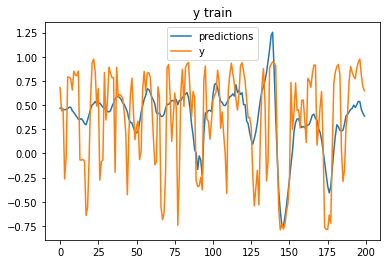

In [2935]:

pd.DataFrame({'predictions':train_predictions_pnr_bar.ravel()[:200],'y':y_pnr_bac.ravel()[:200]}).plot(title='y train')

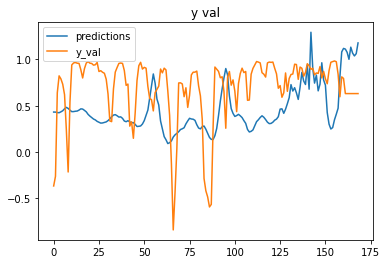

In [2936]:

pd.DataFrame({'predictions':val_predictions_pnr_bac.ravel(),'y_val':y_val_pnr_bac.ravel()[:200]}).plot(title='y val')

# Kalman Filter

In [239]:
final_stock_df.shape

(3486, 7610)

In [ ]:
pg_so_close_corr_rolling_7_days

In [258]:
n_cols = 7609

In [263]:
np.array([np.random.standard_normal(n_cols), np.random.standard_normal(n_cols), np.random.standard_normal(n_cols)]).T.shape

(7609, 3)

In [530]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [1237]:
def pos_vel_filter(x, P, R, Q=.1, dt=1.0, d_t2=.2):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    shape_x = len(x) #.shape[1]
    print(shape_x, ' shape x')
    
    kf = KalmanFilter(dim_x=shape_x, dim_z=shape_x) # three elements for measurement, the measurement, the velocity, and the acceleration. True measurement is one D
    kf.x = x #np.array([x[0], x[1], x[2]]) # location and velocity and acceleration for corre 7 and corr 3
    kf.F = np.eye(shape_x)
    #np.array([[1., dt, d_t2,], #0, 0, 0],
     #                [0., 1., 0,], #0, 0, 0],
      #               [0., 0., 1.]]) # ,0, 0, 0],
#                      [0., 0., 0. , 1., 0, 0],
#                      [0., 0., 0., 0., 1., 0],
#                      [0., 0., 0., 0., 0., 1.]])  # state transition matrix
#     kf.H = np.array([[1., 0]])    # Measurement function
    kf.H = np.ones(7610) #np.array([1,0,0]) # get the measurements 
    kf.R *= np.array([[R]])                     # measurement uncertainty, only one sensor
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = np.ones(shape_x)  * np.random.randn()/1000   #Q_discrete_white_noise(dim=2, dt=dt, var=Q) ## no measurement noise, have perfect measurements
        #np.ones(shape_x) * np.random.randn()/1000  #
    else:
        kf.Q[:] = Q
    return kf

In [1238]:
np.ones(7610).reshape(1,-1).shape

(1, 7610)

In [1239]:
np.array([[1,1]]).shape

(1, 2)

In [1240]:
len(np.array([[1,1]]))

1

In [1241]:
dt = .3
x = np.array([[0., 2., .3]]) 
kf = pos_vel_filter(x, P=.1, R=.5, Q=0.1, dt=dt) # P is covariance

1  shape x


In [1242]:
kf

KalmanFilter object
dim_x = 1
dim_z = 1
dim_u = 0
x = [[0.  2.  0.3]]
P = [[0.1]]
x_prior = [[0.]]
P_prior = [[1.]]
x_post = [[0.]]
P_post = [[1.]]
F = [[1.]]
Q = [-0.00087083]
R = [[0.5]]
H = [1. 1. 1. ... 1. 1. 1.]
K = [[0.]]
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x11091d0d0>

## Historical testing

In [1253]:
def evaluate_predictions_on_rolling_historical_data(final_stock_df, rolling_window = 7, starting_date_index= 3350,
                                                   y_col='pg_so_close_corr_rolling_7_days', y_col_corr_3_day='pg_so_close_corr_rolling_3_days',
                                                    print_idx = 10):
    """
    Backtesting
    
    For now, assumes the final_stock only has pairs the one start stock and all others, pnc_bac, pnc_bar ...etc
    """
    final_stock_df = final_stock_df.dropna()
    
    predicted_corr_7_days = []
    actual = []
    rmse_corr_7_days = []
    prediction_date = []
    
    kf_cov = []


     # otherwise, takes too long
    start = time.time()

    final_row = None
    first_loop = True
    


        
    for date_idx, date in enumerate(list(final_stock_df.index)[starting_date_index:]):
#         print((date_id + starting_date_index+rolling_window+1))
#         print(len(final_stock_df))

        if final_row:
            break
        if (date_idx + starting_date_index +rolling_window +1) == len(final_stock_df): # last row
            final_row = True
            # need to use the dates from the DF due to weekends
            train_dates = final_stock_df.index[:starting_date_index+date_idx]
            # The test is the rolling 7-day corr looking back the past seven days
            # Therefore, the test_date should be seven dates ahead of the data we are training on

            test_date = final_stock_df.index[starting_date_index+rolling_window+date_idx]

        else:
            # need to use the dates from the DF due to weekends
            train_dates = final_stock_df.index[:starting_date_index+date_idx+1]
            # The test is the rolling 7-day corr looking back the past seven days
            # Therefore, the test_date should be seven dates ahead of the data we are training on

            test_date = final_stock_df.index[starting_date_index+rolling_window+date_idx+1]


        prediction_date.append(test_date)

        if date_idx % print_idx == 0:
            print(f"Train dates =  {train_dates}")
            print(F"Prediction date = {test_date}")

        train_df = final_stock_df[final_stock_df.index.isin(list(train_dates))]
        previous_test_date_df = final_stock_df[final_stock_df.index == final_stock_df.index[starting_date_index+rolling_window+date_idx-1]]
        previous_test_date_df[f"{y_col}"] = previous_test_date_df[f"{y_col}"].shift(-7).fillna(method='ffill') 
    
        test_df = final_stock_df[final_stock_df.index == test_date]
        
        # put data in the past for prediction X
        test_X_df = final_stock_df.shift(-7).fillna(method='ffill') 
        test_X_df= test_X_df[test_X_df.index == test_date]


        # TODO - search for the rolling 7-days column, don't hardcode
        X_train, y_train = train_df.loc[:, train_df.columns != f"{y_col}"],  train_df[f"{y_col}"].shift(-7).fillna(method='ffill') 
        X_test, y_test = test_X_df.loc[:, test_X_df.columns != f"{y_col}"],  test_df[f"{y_col}"]
        y_test_corr_3_day = previous_test_date_df[f"{y_col_corr_3_day}"]
        
        combined_x_train_test = X_train.join(y_train)

        
        # inf
        X_train = np.nan_to_num(X_train.astype(np.float32)) # converting to float 32 throws some infinity errors
        X_test = np.nan_to_num(X_test.astype(np.float32)) # converting to float 32 throws some infinity errors  
        combined_x_train_test = np.nan_to_num(combined_x_train_test.astype(np.float32)) 
        previous_test_date_df = np.nan_to_num(previous_test_date_df.astype(np.float32)) 
        
        
        # standard scaler for cols
        scaler=StandardScaler()
        scaler.fit(combined_x_train_test)
#         scaler.fit(X_train)
#         X_train = scaler.transform(X_train)
#         X_test = scaler.transform(X_test)
        combined_x_train_test = scaler.transform(combined_x_train_test)
        previous_test_date_df = scaler.transform(previous_test_date_df)



        # Make an instance of the Model
        # only train on train_x and transform both train an test

#         pca = PCA(.90, whiten=True)
#         pca.fit(X_train)
#         X_train = pca.transform(X_train)
#         X_test = pca.transform(X_test)




        #estimator = GradientBoostingRegressor()
#         estimator_two = RandomForestRegressor(n_jobs=-1)
#         estimator_one = SVR(C=50.0, kernel='poly')

#         estimator_one.fit(X_train, y_train)
#         estimator_two.fit(X_train, y_train)

#         prediction_one = estimator_one.predict(X_test)
#         prediction_two = estimator_two.predict(X_test)
#         prediction = prediction_one[0] #np.mean([prediction_one[0], prediction_two[0] ])


            # test kalman filter
        if first_loop:
            dt = .8
            x = np.array(previous_test_date_df).ravel() #  initial  state-corr7,  velocity-corr7, acceleration-corr7, state-corr3,  velocity-corr3, acceleration-corr3
            print('initial state = ', x)
            kf = pos_vel_filter(x, P=.5, R=.5, Q=0.1, dt=dt) # P is covariance

            previous_velocity_y_corr_7 = None
            first_loop = False
    
        kf.predict()
        eq = final_stock_df.columns == f"{y_col}"
        y_col_idx = np.where(eq == True)[0][0]
        
        prediction = scaler.inverse_transform(kf.x)[y_col_idx] #  is the prediction


#         if previous_velocity_y_corr_7 is None:
#             current_velocity_y_corr_7 =  (y_test.values[0] + previous_test_date_df[f"{y_col}"].values[0]) / 2
#             current_velocity_y_corr_3 = (y_test_corr_3_day.values[0]+ previous_test_date_df[f"{y_col_corr_3_day}"].values[0]) / 2
                                         
#             y_true = np.array([y_test.values[0], current_velocity_y_corr_7, current_velocity_y_corr_7 / 2]) #, 
# #                                y_test_corr_3_day.values[0], current_velocity_y_corr_3, current_velocity_y_corr_3/2 ])
#             previous_velocity_y_corr_7 = current_velocity_y_corr_7
#             previous_velocity_y_corr_3 = current_velocity_y_corr_3
#         else:
#             current_velocity_y_corr_7 =  (y_test.values[0] + previous_test_date_df[f"{y_col}"].values[0]) / 2
#             current_velocity_y_corr_3 = (y_test_corr_3_day.values[0]+ previous_test_date_df[f"{y_col_corr_3_day}"].values[0]) / 2
            
#             y_true = np.array([y_test.values[0], current_velocity_y_corr_7, (current_velocity_y_corr_7 + previous_velocity_y_corr_7) / 2]) #,
# #                                 y_test_corr_3_day.values[0], current_velocity_y_corr_3, (current_velocity_y_corr_3 + previous_velocity_y_corr_3) / 2])
            
#             previous_velocity_y_corr_7 = current_velocity_y_corr_7
#             previous_velocity_y_corr_3 = current_velocity_y_corr_3
        #kf.update(y_true)
        measurement = np.array(combined_x_train_test[-1,:]).ravel()
        print(measurement, 'measurement')
        kf.update(measurement)

        kf_cov.append(kf.P)
        if date_idx % print_idx == 0:
            print('prediction', prediction)
            print(kf.x, 'kf x')
            print('y_test.values[0]', y_test.values[0])
#             print(y_true, 'y true')

        predicted_corr_7_days.append(prediction)
        actual.append(y_test.values[0])
        

        rmse_corr_7_days.append(np.sqrt(mean_squared_error(y_test, [prediction])))
        if date_idx % print_idx == 0:
            print('prediction = ', prediction)
            print('actual =', y_test.values)
            print('')


    end = time.time()

    print(f"Predictions took {(end-start)/60} minutes")
    
    if len(kf_cov) > 0:
        prediction_df = pd.DataFrame( {'actual_corr_7_days':actual, 'predicted_corr_7_days': predicted_corr_7_days, 
                                       'prediction_date':prediction_date, 'rmse_corr_7_days':rmse_corr_7_days, 'kf_cov': kf_cov})
    else:
        prediction_df = pd.DataFrame( {'actual_corr_7_days':actual, 'predicted_corr_7_days': predicted_corr_7_days, 
                                       'prediction_date':prediction_date, 'rmse_corr_7_days':rmse_corr_7_days})
    return prediction_df

In [1254]:
hist_predictions_df = evaluate_predictions_on_rolling_historical_data(final_stock_df, print_idx=1)

Train dates =  DatetimeIndex(['2006-06-22', '2006-06-23', '2006-06-27', '2006-06-28',
               '2006-06-29', '2006-06-30', '2006-07-05', '2006-07-06',
               '2006-07-07', '2006-07-10',
               ...
               '2019-10-04', '2019-10-07', '2019-10-08', '2019-10-09',
               '2019-10-10', '2019-10-11', '2019-10-14', '2019-10-15',
               '2019-10-16', '2019-10-17'],
              dtype='datetime64[ns]', name='date', length=3351, freq=None)
Prediction date = 2019-10-29 00:00:00
initial state =  [-5.5033141e-01  1.0479934e+00 -2.8389397e-01 ... -5.2031329e+02
  2.2180166e+04 -7.3766232e-01]
7610  shape x
[ 1.1577859   0.13769396 -0.7042416  ...  1.6490798  -0.0917939
  0.9583094 ] measurement
prediction 2.0477805395824333e-08
[-3.01981389e+00 -1.42148905e+00 -2.75337645e+00 ... -5.22782776e+02
  2.21776965e+04 -3.20714479e+00] kf x
y_test.values[0] -0.042001
prediction =  2.0477805395824333e-08
actual = [-0.042001]

Train dates =  DatetimeIndex(['2006-

KeyboardInterrupt: 

In [1136]:
np.array(final_stock_df.iloc[-1,:]).reshape(1,-1).shape

(1, 7610)

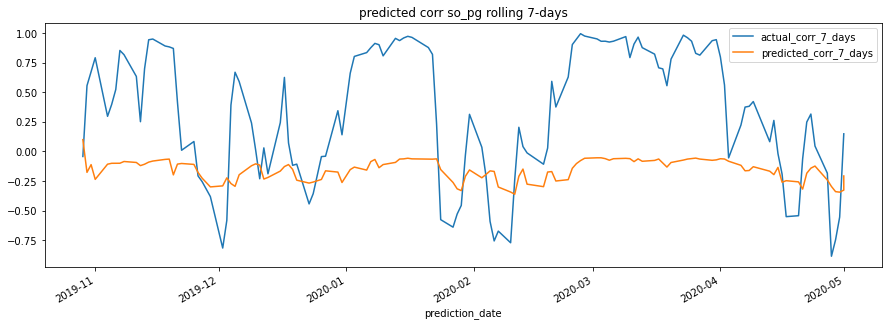

In [806]:
#current kalman filter
hist_predictions_df.set_index('prediction_date')[['actual_corr_7_days', 'predicted_corr_7_days']].plot(title='predicted corr so_pg rolling 7-days', figsize=(15,5))

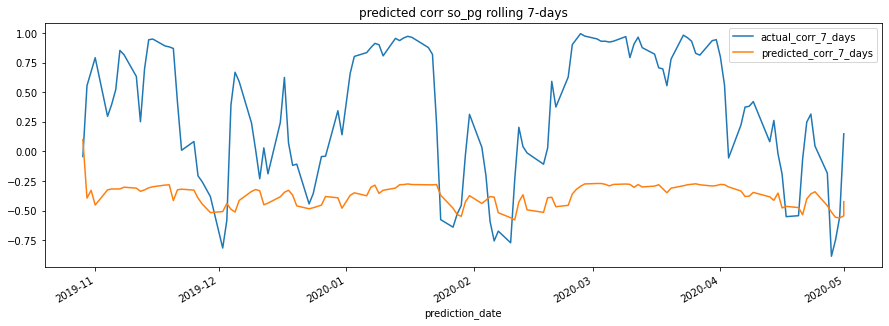

In [855]:
#previous kalman filter
hist_predictions_df.set_index('prediction_date')[['actual_corr_7_days', 'predicted_corr_7_days']].plot(title='predicted corr so_pg rolling 7-days', figsize=(15,5))

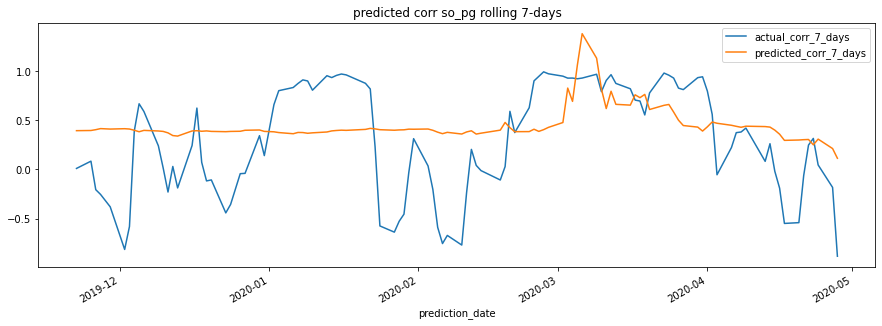

In [84]:
#poly kernel + Rf 
hist_predictions_df.set_index('prediction_date')[['actual_corr_7_days', 'predicted_corr_7_days']].plot(title='predicted corr so_pg rolling 7-days', figsize=(15,5))

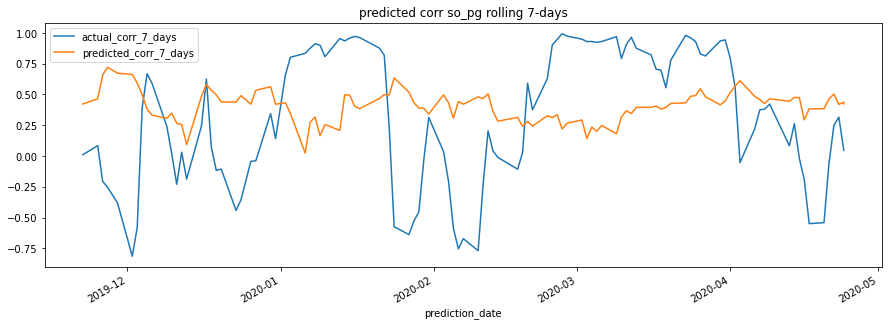

In [368]:
# previous predictions
hist_predictions_df.set_index('prediction_date')[['actual_corr_7_days', 'predicted_corr_7_days']].plot(title='predicted corr so_pg rolling 7-days', figsize=(15,5))

In [46]:
np.sqrt(mean_squared_error(hist_predictions_df.actual_corr_7_days, hist_predictions_df.predicted_corr_7_days)) # rf

0.5494686495183007

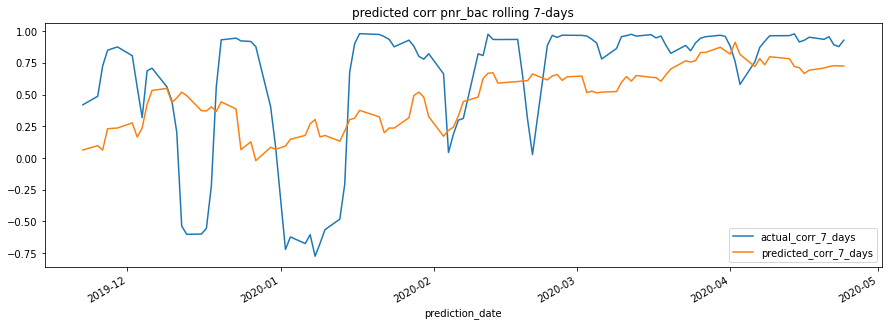

In [325]:
hist_predictions_df.set_index('prediction_date')[['actual_corr_7_days', 'predicted_corr_7_days']].plot(title='predicted corr pnr_bac rolling 7-days', figsize=(15,5))

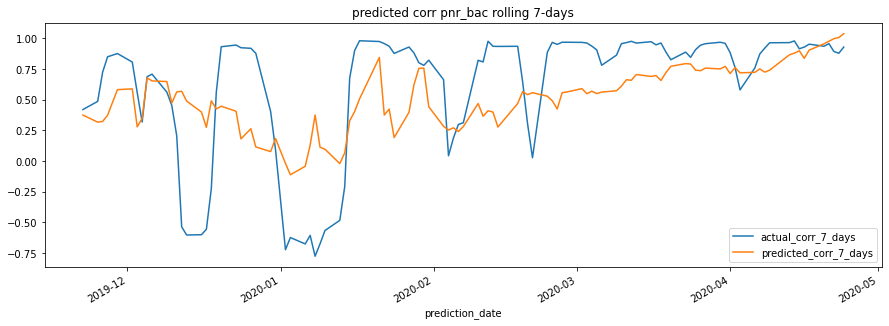

In [312]:
# svm rfb kernel
hist_predictions_df.set_index('prediction_date')[['actual_corr_7_days', 'predicted_corr_7_days']].plot(title='predicted corr pnr_bac rolling 7-days', figsize=(15,5))

In [510]:
prediction_df.index

DatetimeIndex(['2019-11-20', '2019-11-21', '2019-11-22', '2019-11-25',
               '2019-11-26', '2019-11-27', '2019-11-29', '2019-12-02',
               '2019-12-03', '2019-12-04',
               ...
               '2020-04-03', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-13', '2020-04-14', '2020-04-15',
               '2020-04-16', '2020-04-16'],
              dtype='datetime64[ns]', name='prediction_date', length=102, freq=None)

## Feature Importances
- nit: only based on last tree fit

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

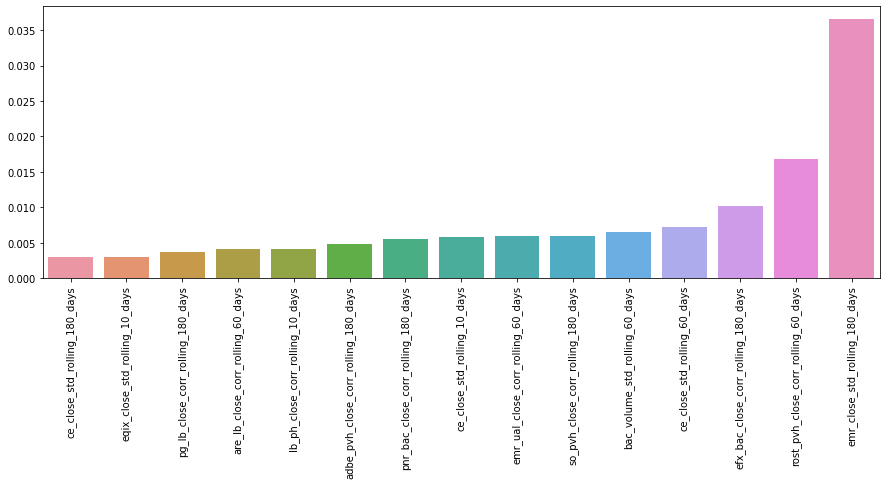

In [1301]:
cols = list(final_stock_df.columns)
cols.remove('pnr_bac_close_corr_rolling_7_days')

plt.figure(figsize=(15,5))
sns.barplot(x=np.array(cols)[np.argsort(rf.feature_importances_)][-15:], y=rf.feature_importances_[np.argsort(rf.feature_importances_)][-15:])
plt.xticks(rotation=90)

# given all feature, predict next 7-days for each stock pair

In [1182]:
final_stock_df.pnr_bac_close_corr_rolling_3_days.shift(-1).fillna(method='ffill')

date
2006-01-25    0.151438
2006-01-26    0.263368
2006-01-27   -0.675648
2006-01-30   -0.245173
2006-01-31    0.848353
                ...   
2020-04-20    0.928298
2020-04-21    0.979311
2020-04-22    0.992304
2020-04-23    0.985425
2020-04-24    0.985425
Name: pnr_bac_close_corr_rolling_3_days, Length: 3586, dtype: float64

In [1013]:
np.nan_to_num(final_stock_df.astype(np.float32)

array([[1.609430e-01, 8.503500e-02, 3.168980e-01, ..., 1.000000e+00,
        1.000000e+00, 2.006000e+03],
       [1.514380e-01, 8.503500e-02, 3.126760e-01, ..., 1.000000e+00,
        1.000000e+00, 2.006000e+03],
       [2.633680e-01, 6.827510e-01, 1.288730e-01, ..., 1.000000e+00,
        1.000000e+00, 2.006000e+03],
       ...,
       [6.691380e-01, 5.577040e-01, 9.487360e-01, ..., 4.000000e+00,
        2.000000e+00, 2.020000e+03],
       [9.991570e-01, 8.747000e-01, 1.176194e+00, ..., 4.000000e+00,
        2.000000e+00, 2.020000e+03],
       [9.890840e-01, 5.907060e-01, 9.345770e-01, ..., 4.000000e+00,
        2.000000e+00, 2.020000e+03]], dtype=float32)

- build predicted 7 day corr for each pair

In [1170]:
# remove all 7_days_corr columns ex: so_rost_close_corr_rolling_7_days
### format: f"{first_stock_name}_{second_stock_name}_close_corr_rolling_{n_days_stride}_days"
# using all data up until the last day, predict 7-day corr for each stock pair

In [ ]:
# undefined
find_pct_change_pred_vs_last_corr

In [392]:
final_stock_df.index.max() # what is the max date?

Timestamp('2020-04-27 00:00:00')

In [393]:
final_stock_df.index.min()

Timestamp('2017-03-16 00:00:00')

In [1193]:
def most_recent_week_historical_prediction(final_stock_df):
    """
    Take the most recent week of data and use that to predict against 
    """

    test_date = final_stock_df.index.max() - datetime.timedelta(7)
    train_dates = final_stock_df.index[final_stock_df.index < test_date - datetime.timedelta(14)] # 14 days before

    train_df = final_stock_df[final_stock_df.index.isin(train_dates)]
    test_df = final_stock_df[final_stock_df.index == test_date]


    final_stock_df = final_stock_df.dropna()

    n_days_corr_predictions = 7


    pct_change_corr = []
    actual_corr = []
    predicted_corr = []
    last_corr_for_prediction_day = []
    pred_dates = []
    start = time.time()

    for stock_pairing in pairs_of_stocks:
        pred_col_name = f"{stock_pairing}_close_corr_rolling_{n_days_corr_predictions}_days"

        # remove the current 7-day corr for this stock
        # we can't use  test_X data because we will not have access to it
        train_X, train_y = train_df.loc[:, train_df.columns != f"{pred_col_name}"],  train_df[f"{pred_col_name}"].shift(-7).fillna(method='ffill')# shift back 7 days to get rolling corr
        
        test_X, test_y = test_df.loc[:, test_df.columns != f"{pred_col_name}"],  test_df[f"{pred_col_name}"].shift(-7).fillna(method='ffill') # test has the date we want to predict against


        train_X = np.nan_to_num(train_X.astype(np.float32)) 

        # standard scaler for cols
        scaler=StandardScaler()
        scaler.fit(train_X)
        train_X = scaler.transform(train_X)
        test_X = scaler.transform(test_X)


        # Make an instance of the Model
        # only train on train_x

        pca = PCA(.60, whiten=True)
        pca.fit(train_X)

        train_X = pca.transform(train_X)
        test_X = pca.transform(test_X)
        # standaard scaler
        
        estimator_two = RandomForestRegressor(n_jobs=-1)
        estimator_one = SVR(C=.5, kernel='rbf')

        estimator_one.fit(X_train, y_train)
        estimator_two.fit(X_train, y_train)

        prediction_one = estimator_one.predict(X_test)
        prediction_two = estimator_two.predict(X_test)
        prediction = np.mean([prediction_one[0], prediction_two[0] ])


        print(f"Stocks {stock_pairing}")
        print(f"Prediction = {prediction}")
        print(f"Actual = {test_y.values[0]}")

        pred_corr_pct_change, last_date = find_pct_change_pred_vs_last_corr(train_y, prediction)

        last_corr_date = train_y.index.max()
        last_corr = train_y[train_y.index.max()]    

        pct_change_corr.append(pred_corr_pct_change)
        pred_dates.append(last_date)
        actual_corr.append(test_y.values[0])
        predicted_corr.append(prediction)
        last_corr_for_prediction_day.append(last_corr)

        print(f"{stock_pairing} pct change 7-day corr of close from {last_date} to {test_date} is =  {pred_corr_pct_change}")


    end = time.time()

    print(f"Predictions took {(end-start)/60} mins")
    
    pd.DataFrame({ 'pred_date_start':pred_dates,'stock_pair':pairs_of_stocks,   'pct_change_for_7_daycorr': pct_change_corr,
    'actual_corr': actual_corr,
    'predicted_corr': predicted_corr, 'last_7_day_corr_for_pred_date_start': last_corr_for_prediction_day}).to_csv(
    '../data/predictions/test_predictions_2020_04_17.csv', index=False)
    


In [1194]:
most_recent_week_historical_prediction(final_stock_df)

/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


ValueError: Number of labels=3586 does not match number of samples=3580

most_recent_week_historical_prediction

# Final Predictions

In [94]:
# add this to predictions
stock_to_industry = pd.read_csv('../data/Industries stock list - all.csv')
stock_to_industry.symbol = [i.lower() for i in stock_to_industry.symbol]

In [95]:
final_stock_df.index.min()

Timestamp('1980-01-01 00:00:00')

In [35]:
# train on all data
# predict for the upcoming week

def prediction_for_upcoming_week(final_stock_df,pairs_of_stocks, job_id=None, verbose = True, print_idx=10):
    final_stock_df = final_stock_df.dropna()
    # add this to predictions
    stock_to_industry = pd.read_csv('../data/Industries stock list - all.csv')
    stock_to_industry.symbol = [i.lower() for i in stock_to_industry.symbol]

    final_stock_df = final_stock_df.dropna()
    most_recent_date = final_stock_df.index.max()

    prediction_end = most_recent_date + datetime.timedelta(7)



    test_df = final_stock_df[final_stock_df.index == most_recent_date]

    

    n_days_corr_predictions = 7


    pct_change_corr = []
    predicted_corr = []
    last_corr_for_prediction_day = []
    pred_dates = []
    first_stock_industries = []
    second_stock_industries = []

    start = time.time()
    total_n = len(pairs_of_stocks)
    
    for idx,stock_pairing in enumerate(pairs_of_stocks):
        if idx % print_idx == 0 and verbose:
            print('----------')
            print(f"Stock pairing = {stock_pairing}")
            print(f"Pct finished = {idx/total_n}")
        first_stock_name, second_stock_name = stock_pairing.split('_')

        first_stock_industries.append(stock_to_industry[stock_to_industry.symbol == first_stock_name].industry.values[0])
        second_stock_industries.append(stock_to_industry[stock_to_industry.symbol == second_stock_name].industry.values[0])



        pred_col_name = f"{stock_pairing}_close_corr_rolling_{n_days_corr_predictions}_days"

        # remove the current 7-day corr for this stock
        # for 7 take rolling 7 days corr to the present day to predict off of
        train_X, train_y = final_stock_df.loc[:, final_stock_df.columns != f"{pred_col_name}"],  final_stock_df[f"{pred_col_name}"].shift(-7).fillna(method='ffill') 
                                                           # get corr from 7 days in the future


        test_X, test_y = test_df.loc[:, test_df.columns != f"{pred_col_name}"],  test_df[f"{pred_col_name}"]

        train_X = np.nan_to_num(train_X.astype(np.float32))

        test_X = np.nan_to_num(test_X.astype(np.float32)) 

        # standard scaler for cols
        scaler=StandardScaler()
        scaler.fit(train_X)
        train_X = scaler.transform(train_X)
        test_X = scaler.transform(test_X)
        
        
        # do this again for standard scaler
        train_X = np.nan_to_num(train_X.astype(np.float32))
        test_X = np.nan_to_num(test_X.astype(np.float32)) 


        # Make an instance of the Model
        # only train on train_x

        pca = PCA(.60, whiten=True)

        pca.fit(train_X)

        train_X = pca.transform(train_X)
        test_X = pca.transform(test_X)

        # standaard scaler

#         estimator_two = RandomForestRegressor(n_jobs=-1)
        estimator_one = SVR(C=5.0, kernel='poly')

        estimator_one.fit(train_X, train_y)
#         estimator_two.fit(train_X, train_y)

        prediction_one = estimator_one.predict(test_X)
#         prediction_two = estimator_two.predict(test_X)
        prediction =  prediction_one[0] #np.mean([prediction_one[0], prediction_two[0] ])

        if verbose and idx % print_idx==0:
            print(f"Prediction = {prediction}")


        last_corr_date = train_y.index.max()
        last_corr = train_y[train_y.index.max()]  
        if verbose and idx % print_idx==0:
            print(f"Last corr = {last_corr}")

        pred_dates.append(most_recent_date)
        predicted_corr.append(prediction)
        last_corr_for_prediction_day.append(last_corr)
        
        if verbose and idx % print_idx==0:
            print(f"{stock_pairing} corr7-day corr of close from {most_recent_date} to {prediction_end} is {prediction} ")


    end = time.time()

    print(f"Predictions took {(end-start)/60} mins")

    squarred_difference = (np.array(last_corr_for_prediction_day)-np.array(predicted_corr))**2

    prediction_df = pd.DataFrame({ 'pred_date_start':pred_dates,'stock_pair':pairs_of_stocks,   'first_stock_industry': first_stock_industries, 
                   'second_stock_industry': second_stock_industries,
                   'predicted_corr': predicted_corr, 'last_7_day_corr_for_pred_date_start': last_corr_for_prediction_day, 
            'squarred_diff_7_day_cor': (np.array(last_corr_for_prediction_day)-np.array(predicted_corr))**2
                 })
    
    if job_id:
        tmp_filepath = '../data/tmp_prediction_dfs'
        if not os.path.isdir(f"{tmp_filepath}"):
            os.mkdir(f"{tmp_filepath}")
        prediction_df.to_csv(
        f'{tmp_filepath}/{job_id}_test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)
    else:
        prediction_df.to_csv(
    f'../data/predictions/pca_test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)


In [36]:
def chunks(l, n):
    return [l[i:i+n] for i in range(0, len(l), n)]

def do_job(job_id, stock_pairs, data_slice):
    all_prediction_df = []
    prediction_for_upcoming_week(data_slice, stock_pairs, job_id=job_id)



def dispatch_jobs(data, job_number, pairs):
    total = len(pairs)
    chunk_size = total / job_number
    slice = chunks(pairs, int(chunk_size))
    jobs = []

    for i, pair in enumerate(slice):
        j = Process(target=do_job, args=(i, pair, data))
        jobs.append(j)
    for j in jobs:
        j.start()

In [37]:


num_workers = mp.cpu_count()  

In [38]:
num_workers

8

In [39]:
len(pairs_of_stocks)

1485

In [40]:
if __name__ == '__main__':
    final_stock_df = final_stock_df.dropna()
    num_workers = mp.cpu_count()  
    dispatch_jobs(final_stock_df, num_workers , pairs_of_stocks)

----------
Stock pairing = pbj_colb
Pct finished = 0.0
----------
Stock pairing = wabc_bac
Pct finished = 0.0
----------
Stock pairing = wal_pfbc
Pct finished = 0.0
----------
Stock pairing = cwbc_vti
----------
----------
Pct finished = 0.0
Stock pairing = dlr_frc
Stock pairing = jpm_c
Pct finished = 0.0
Pct finished = 0.0
----------
Stock pairing = cvbf_ntrs
Pct finished = 0.0
----------
Stock pairing = ntrs_cma
Pct finished = 0.0
----------
Stock pairing = frc_cpt
Pct finished = 0.0
Prediction = 0.8568563614790041
Last corr = 0.956929
jpm_c corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.8568563614790041 
Prediction = 0.8343273600801935
Last corr = 0.934556
wabc_bac corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.8343273600801935 
Prediction = 0.40979355389807526
Prediction = 0.8857304450640736
Prediction = 0.8454579055888495
Last corr = 0.50611
pbj_colb corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 

Process Process-10:
Traceback (most recent call last):
  File "/Users/jonathanhilgart/.pyenv/versions/3.7.0/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jonathanhilgart/.pyenv/versions/3.7.0/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-36-bbbb3f9032f4>", line 6, in do_job
    prediction_for_upcoming_week(data_slice, stock_pairs, job_id=job_id)
  File "<ipython-input-35-fe6b246a3283>", line 87, in prediction_for_upcoming_week
    estimator_one.fit(train_X, train_y)
  File "/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py", line 148, in fit
    accept_large_sparse=False)
  File "/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/sklearn/utils/validation.py", line 761, in check_X_y
    _assert_all_finite(y

Prediction = 0.9182281016991054
Last corr = 0.961643
jpm_vno corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.9182281016991054 
Prediction = 0.763210387216575
Last corr = 0.854016
wabc_pej corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.763210387216575 
Prediction = 0.8601220778266219
Last corr = 0.924213
ntrs_bjk corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.8601220778266219 
Prediction = 0.7800389235234828
Last corr = 0.880271
cwbc_bmrc corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.7800389235234828 
Prediction = 0.8924037361537163
Last corr = 0.992603
cvbf_colb corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.8924037361537163 
Prediction = 0.33963999902663916
Last corr = 0.372786
pbj_usb corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.33963999902663916 
Prediction = 0.7306198678136352
Last corr = 0.8305
spy_cma

Process Process-13:
Traceback (most recent call last):
  File "/Users/jonathanhilgart/.pyenv/versions/3.7.0/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jonathanhilgart/.pyenv/versions/3.7.0/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-36-bbbb3f9032f4>", line 6, in do_job
    prediction_for_upcoming_week(data_slice, stock_pairs, job_id=job_id)
  File "<ipython-input-35-fe6b246a3283>", line 87, in prediction_for_upcoming_week
    estimator_one.fit(train_X, train_y)
  File "/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py", line 148, in fit
    accept_large_sparse=False)
  File "/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/sklearn/utils/validation.py", line 761, in check_X_y
    _assert_all_finite(y

----------
Stock pairing = jpm_cpg
Pct finished = 0.10810810810810811
----------
Stock pairing = ntrs_sivb
Pct finished = 0.10810810810810811
----------
Stock pairing = bac_bmrc
Pct finished = 0.10810810810810811
----------
Stock pairing = cvbf_usb
Pct finished = 0.10810810810810811
----------
Stock pairing = spy_bjk
Pct finished = 0.10810810810810811
----------
Stock pairing = pbj_frc
Pct finished = 0.10810810810810811
Prediction = 0.7885844171843135
Last corr = 0.888479
ntrs_sivb corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.7885844171843135 
Prediction = 0.5489372593214044
Last corr = 0.635174
jpm_cpg corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.5489372593214044 
Prediction = 0.8486805497851307
Last corr = 0.935181
bac_bmrc corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.8486805497851307 
Prediction = 0.8440486956060845
Last corr = 0.944286
cvbf_usb corr7-day corr of close from 2020-05-15 00:

Process Process-12:
Traceback (most recent call last):
  File "/Users/jonathanhilgart/.pyenv/versions/3.7.0/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jonathanhilgart/.pyenv/versions/3.7.0/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-36-bbbb3f9032f4>", line 6, in do_job
    prediction_for_upcoming_week(data_slice, stock_pairs, job_id=job_id)
  File "<ipython-input-35-fe6b246a3283>", line 87, in prediction_for_upcoming_week
    estimator_one.fit(train_X, train_y)
  File "/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/sklearn/svm/_base.py", line 148, in fit
    accept_large_sparse=False)
  File "/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/daily-trading-nJ43NNNI-py3.7/lib/python3.7/site-packages/sklearn/utils/validation.py", line 761, in check_X_y
    _assert_all_finite(y

----------
Stock pairing = cvbf_spy
Pct finished = 0.972972972972973
----------
Stock pairing = hiw_cpt
Pct finished = 0.972972972972973
----------
Stock pairing = cpg_frc
Pct finished = 0.972972972972973
----------
Stock pairing = lamr_cpg
Pct finished = 0.972972972972973
----------
Stock pairing = pacw_frc
Pct finished = 0.972972972972973
Prediction = 0.7475010876354978
Last corr = 0.847441
cvbf_spy corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.7475010876354978 
Prediction = 0.8494408538474634
Last corr = 0.949475
hiw_cpt corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.8494408538474634 
Prediction = 0.6795117644352154
Last corr = 0.76156
cpg_frc corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.6795117644352154 
Prediction = 0.6628584623127102
Last corr = 0.763191
lamr_cpg corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.6628584623127102 
Prediction = 0.8767259760423303


In [42]:
# combine DFs and delete
import shutil

most_recent_date = final_stock_df.index.max()
prediction_end = most_recent_date + datetime.timedelta(7)
tmp_filepath = '../data/tmp_prediction_dfs'
list_of_dfs = []
for file in glob.glob(f"{tmp_filepath}/*.csv"):
    list_of_dfs.append(pd.read_csv(file))

final_df = pd.concat(list_of_dfs)
final_df.to_csv(
    f'../data/predictions/svm_test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)
# final_df = pd.read_csv(f'../data/predictions/test_predictions_{most_recent_date}-{prediction_end}.csv')
# final_df.to_csv(f'../data/predictions/test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)
# clean up old directory
# import shutil


shutil.rmtree(f"{tmp_filepath}")


ValueError: No objects to concatenate

In [2253]:
shutil.rmtree(f"{tmp_filepath}")

In [143]:
final_df

,pred_date_start,stock_pair,first_stock_industry,second_stock_industry,predicted_corr,last_7_day_corr_for_pred_date_start,squarred_diff_7_day_cor
0,2020-04-29,tpr_iwm,retail,etf,0.989086,0.963172,0.000672
1,2020-04-29,tpr_so,retail,utilities,0.542329,0.442207,0.010024
2,2020-04-29,tpr_rost,retail,retail,0.922886,0.967961,0.002032
3,2020-04-29,tpr_eqix,retail,real estate,0.134707,0.034854,0.009971
4,2020-04-29,tpr_spy,retail,etf,0.946083,0.846001,0.010016
...,...,...,...,...,...,...,...
118,2020-04-29,efx_lb,professional services,retail,0.696844,0.729324,0.001055
119,2020-04-29,efx_pvh,professional services,apparel,0.884601,0.984677,0.010015
120,2020-04-29,efx_dia,professional services,etf,0.825228,0.921122,0.009196
121,2020-04-29,efx_pg,professional services,household products,-0.850017,-0.949951,0.009987


In [145]:
r =  pd.read_csv(f'../data/predictions/test_predictions_{most_recent_date}-{prediction_end}.csv')

In [149]:
r.to_csv('test.csv')

In [154]:
r.to_csv(f'../data/predictions/test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)


In [155]:
most_recent_date

Timestamp('2029-12-18 00:00:00')

In [156]:
prediction_end

Timestamp('2029-12-25 00:00:00')